### aim: latitudinally-averaged surface variable

### date: 

available variables, for reference
ptrc - ['deptht_bounds', 'Alkalini', 'time_centered_bounds', 'time_counter_bounds', 'O2', 'DIC', 'PIIC', 'NO3', 'Si', 'PO4', 'Fer', 'DOC', 'CaCO3', 'ARA', 'POC', 'GOC', 'BAC', 'PRO', 'PTE', 'MES', 'GEL', 'MAC', 'DIA', 'MIX', 'COC', 'PIC', 'PHA', 'FIX', 'C11', 'B14B', 'C14B', 'D14B']

diad - ['deptht_bounds', 'DOCTRP', 'time_centered_bounds', 'time_counter_bounds', 'EXP', 'GRAMIC', 'GRAMES', 'GRAMAC', 'PPTDOC', 'PPT', 'TChl', 'Detrit', 'Carniv', 'Herbiv', 'GRAMICPHY', 'GRAMESPHY', 'GRAMACPHY', 'nitrfix', 'denitr', 'DELO2', 'vsink', 'sinksil', 'discarb', 'ExpCO3', 'ExpARA', 'GRAGEL', 'GRAPTE', 'proara', 'prococ', 'D14PRO', 'D14RES', 'fdecay', 'bdecay', 'ddecay', 'qtrC14b', 'qtrB14b', 'qtrD14b', 'qintC14b', 'Cflx', 'PICflx', 'Oflx', 'dpCO2', 'pCO2', 'PPINT']

grid_T - ['deptht_bounds', 'e3t', 'time_centered_bounds', 'time_counter_bounds', 'votemper', 'vosaline', 'tos', 'sos', 'zos', 'mldkz5', 'mldr10_1', 'somxl030', 'wfo', 'rsntds', 'tohfls', 'sosflxdo', 'taum', 'sowindsp', 'soprecip', 'sbt']

In [74]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [75]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [76]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [77]:
def make_yearlist(yrst, yrend, dtype, modnam):
    '''
    open many files together as the same dataset
    ylist = make_yearlist(2001,2011,'diad_T','TOM12_TJ_1AS1')
    ds = xr.open_mfdataset(ylist)
    
    '''
    bD = f'/gpfs/afm/greenocean/software/runs/{modnam}/'
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{bD}/ORCA2_1m_{yrs[i]}0101_{yrs[i]}1231_{dtype}.nc'
        ylist.append(ty)
    return ylist

In [78]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:] #size in m3
csize_broad = np.zeros([31,149,182])
for i in range(0,31):
    csize_broad[i,:,:] = tmesh['csize'].values #broadcast area 
cvol = csize_broad * tmesh['e3t_0'][0,:,:,:] * tmesh['tmask'][0,:,:,:] # multiply by e3t and size, volume in m3


In [79]:
## retreive ncs matching the above filetypes for the above years, open
def get_weighted_latmean(yst, yen, dtype, modnam, var):
    ylist = ut.make_yearlist(yst, yen, dtype, modnam)
    tdat = xr.open_mfdataset(ylist)
    lats = (tdat['nav_lat'][:,49])
    
    units = tdat[var].units
    longnam = tdat[var].long_name
    ## yearly averages for the above var for the above years
    tvar = tdat[var].groupby('time_counter.year').mean('time_counter')
    
    # average of the years one 31 x 149 x 182 product
    tvar = np.nanmean(tvar.values, axis = 0)
    
    #surface
    tvar_surf = tvar[0,:,:]
    #appropriately weighted latitudinal mean
    latmean = np.zeros(149)
    for i in range(0,149):
        latmean[i] = np.ma.average(tvar_surf[i,:], weights = tmesh['csize'][i,:])
    return latmean, lats, units, longnam
# plt.plot(latmean, lats) 
#tvar_yearly = tvar.groupby('time_counter.month').mean('time_counter').values

## test code for chlorophyll for 5 different runs

In [80]:
yst = 1955; yen = 1960
dtype =  'diad_T'
var = 'TChl'
modnam = ['TOM12_RW_3G76','TOM12_RW_3G72', 'TOM12_RW_3G74', 'TOM12_RW_3G83', 'TOM12_RW_3G84']

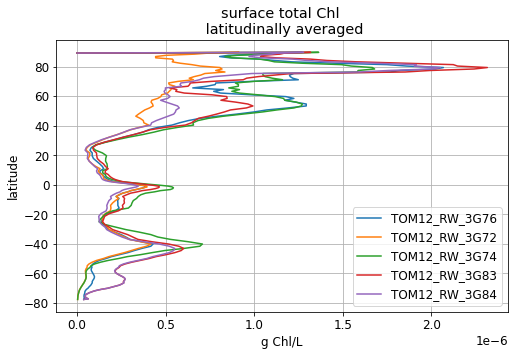

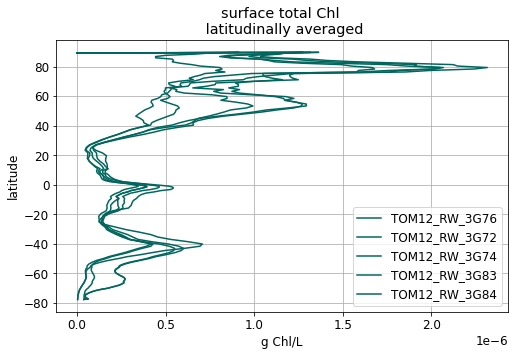

In [81]:
#https://www.rgbtohex.net/
fact = 5
fig, axs = plt.subplots(1,1, figsize=(1.618*fact, 1*fact), facecolor='w', edgecolor='k')

for m in range(0, len(modnam)):
    tmod = modnam[m]
    latmean, lats, units, longnam = get_weighted_latmean(yst, yen, dtype, tmod, var)
    axs.plot(latmean, lats, label = tmod)#, color = '#01665E') 
    axs.set_xlabel(units)
    axs.set_ylabel('latitude')
    axs.set_yticks(np.arange(-80,100,20))
    axs.grid()
    axs.set_title(f'surface {longnam} \n latitudinally averaged')
axs.legend()


#https://www.rgbtohex.net/
fact = 5
fig, axs = plt.subplots(1,1, figsize=(1.618*fact, 1*fact), facecolor='w', edgecolor='k')

for m in range(0, len(modnam)):
    tmod = modnam[m]
    latmean, lats, units, longnam = get_weighted_latmean(yst, yen, dtype, tmod, var)
    axs.plot(latmean, lats, label = tmod, color = '#01665E') 
    axs.set_xlabel(units)
    axs.set_ylabel('latitude')
    axs.set_yticks(np.arange(-80,100,20))
    axs.grid()
    axs.set_title(f'surface {longnam} \n latitudinally averaged')
axs.legend()

## put into a function and test for different variables

In [89]:
def make_summarylat(yst, yen, dtype, modnam, var):
    fact = 5
    fig, axs = plt.subplots(1,1, figsize=(1.618*fact, 1*fact), facecolor='w', edgecolor='k')

    for m in range(0, len(modnam)):
        tmod = modnam[m]
        latmean, lats, units, longnam = get_weighted_latmean(yst, yen, dtype, tmod, var)
        axs.plot(latmean, lats, label = tmod)#, color = '#01665E') 
        axs.set_xlabel(units)
        axs.set_ylabel('latitude')
        axs.set_yticks(np.arange(-80,100,20))
        axs.grid()
        axs.set_title(f'surface {longnam} \n latitudinally averaged')
    axs.legend()



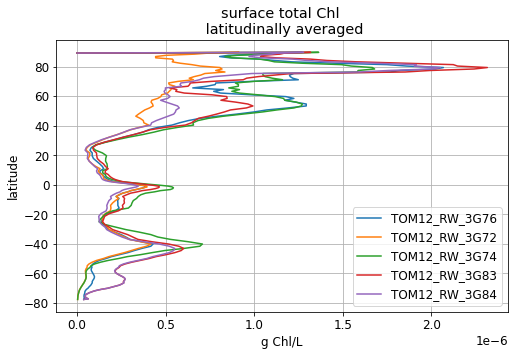

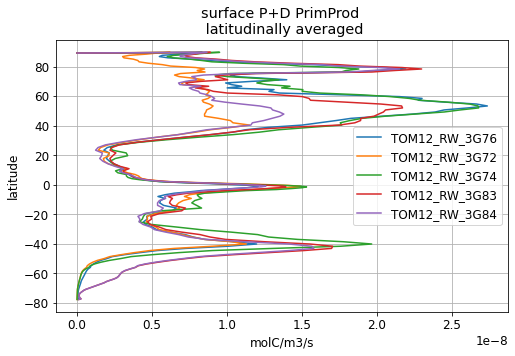

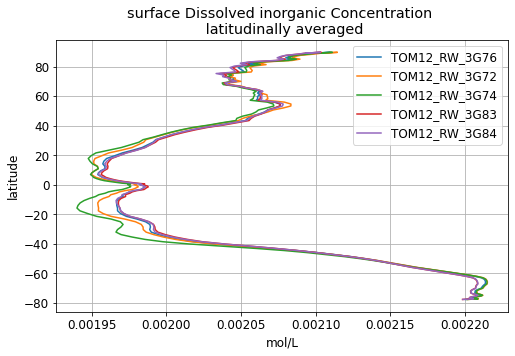

In [92]:
yst = 1955; yen = 1960
dtype =  'diad_T'
var = 'TChl'
modnam = ['TOM12_RW_3G76','TOM12_RW_3G72', 'TOM12_RW_3G74', 'TOM12_RW_3G83', 'TOM12_RW_3G84']

make_summarylat(yst, yen, dtype, modnam, var)

var = 'PPT'
make_summarylat(yst, yen, dtype, modnam, var)

var = 'DIC'
dtype =  'ptrc_T'
make_summarylat(yst, yen, dtype, modnam, var)